# Featurization notebook

*Authors: Enze Chen and Mark Asta (University of California, Berkeley)*

```{note}
This is an interactive exercise, so you will want to click the {fa}`rocket` and open the notebook in DataHub (or Colab for non-UCB students).
```

## Learning objectives

This notebook discuss featurization and how we can apply our domain knowledge to create **physically-meaningful features** for ML applications.
By the end of this notebook, you will be able to:
1. Articulate why it's important to use physically-meaningful features for MI.
1. Use the [`matminer`](https://hackingmaterials.lbl.gov/matminer/) package to featurize chemical formulas.

We will progress through most of this exercise together as a group, and if there's a part that's particularly tricky, please do take time to review it.
As always, we're happy to hear from you if you have any questions.



## Contents

These exercises are grouped into the following sections:

1. [Overview](#Overview)
1. [matminer](#matminer)
1. [Model complexity](#Model-complexity)
1. [Feature selection](#Feature-selection)

## Overview

[Back to top](#Contents)

From our live discussion, we learned that creating physically-meaningful features will **improve interpretability** of our models as well as their **predictive performance**.
This is especially true when we have small and sparse datasets, which tends to be the case for MI applications.
With the right choice of [typically a small number of] features, we might be able to uncover a strong correlation with the target property of interest and simplify our modeling problem.

So far, we've been working with materials datasets and building ML models that _already do this_, so this idea may not be too surprising to you.
For example, it is _because_ we know that the atomic number is correlated with atomic weight that we might choose to use atomic number as a feature to predict the atomic weight, and it turned out to give good performance, even with a simple model like linear regression.
If someone did not know this information, they could use _many more features_ and still _fail to get a good ML model_.
We will now show this is the case.

### First import everything because we're getting lazy

Although, fwiw, if you are sharing notebooks with others, it's not a bad idea to import everything at the top.
That way, if a user does not have a package, they find out right away and can go install it rather than discovering this midway through and having to interrupt their flow. 🌊

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

plt.rcParams.update({'figure.figsize':(8,6),       # Increase figure size
                     'font.size':20,               # Increase font size
                     'mathtext.fontset':'cm',      # Change math font to Computer Modern
                     'mathtext.rm':'serif',        # Documentation recommended follow-up
                     'lines.linewidth':5,          # Thicker plot lines
                     'lines.markersize':12,        # Larger plot points
                     'axes.linewidth':2,           # Thicker axes lines (but not too thick)
                     'xtick.major.size':8,         # Make the x-ticks longer (our plot is larger!)
                     'xtick.major.width':2,        # Make the x-ticks wider
                     'ytick.major.size':8,         # Ditto for y-ticks
                     'ytick.major.width':2,        # Ditto for y-ticks
                     'xtick.direction':'in', 
                     'ytick.direction':'in'})

### Choosing bad features

Now we'll choose a few features that are the column names of our elemental properties DataFrame and we'll store these features into a `features` list.
We then load in the DataFrame, making sure to drop any rows that have `NaN` in those columns (`df.dropna(subset=features)`) so that we can actually perform linear regression.
Feel free to add more features to the list, just don't add `atomic_number`!

There are 94 rows of the data remaining.


,symbol,name,atomic_number,atomic_mass,atomic_radius,row,group,is_metal,electronegativity,density_solid,melting_point,molar_volume,refractive_index,elec_resist,therm_cond,youngs_mod,poissons_ratio
0,H,Hydrogen,1,1.007940,0.25,1,1,False,2.20,NaN,14.01 K,11.42,1.000132 (gas; liquid 1.12)(no units),NaN,0.1805,NaN,NaN
2,Li,Lithium,3,6.941000,1.45,2,1,True,0.98,535.0,453.69 K,13.02,NaN,9.500000e-08,85.0000,4.9,NaN
3,Be,Beryllium,4,9.012182,1.05,2,2,True,1.57,1848.0,1560.0 K,4.85,NaN,3.800000e-08,190.0000,287.0,0.032
4,B,Boron,5,10.811000,0.85,2,13,False,2.04,2460.0,2349.0 K,4.39,NaN,1.000000e+12,27.0000,NaN,NaN
5,C,Carbon,6,12.010700,0.70,2,14,False,2.55,2267.0,3800.0 K,5.29,2.417 (diamond)(no units),1.000000e-05,140.0000,NaN,NaN


The average CV score is 30.196.
The coefficients are [34.85617669 29.31601679  0.36408219], -127.44955536862058.


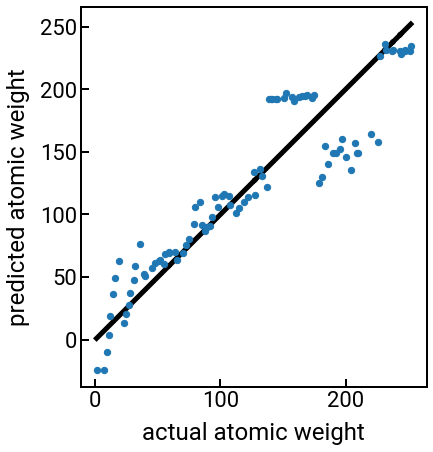

In [2]:
features = ['row', 'electronegativity', 'molar_volume']
df = pd.read_csv('../../assets/data/week_1/04/elem_props.csv')
df = df.dropna(subset=features)
print(f'There are {len(df)} rows of the data remaining.')
display(df.head())

X = df[features]
# X = df[['atomic_number']]    # uncomment this line and see what happens!
y = df['atomic_mass']

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

lr = LinearRegression()
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(lr, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
print(f'The average CV score is {-np.mean(scores):.3f}.')

lr.fit(X, y)
yhat = lr.predict(X)
print(f'The coefficients are {lr.coef_}, {lr.intercept_}.')

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(y, yhat, s=40)
ax.plot(y, y, c='k', zorder=-5)
ax.set_xlabel('actual atomic weight')
ax.set_ylabel('predicted atomic weight')
ax.set_aspect('equal')
plt.show()

**Pause and reflect**: Note how we can use many more features to build our ML model and still create the parity plot the same way as before, since it only depends on the output predictions.
Based on the parity plot, can you tell how your choice of features are being leveraged for the prediction?


What you should observe is that using any combination of the other provided features basically sucks for predicting the atomic weight, and as soon as we switch to atomic number, everything is right with the world. 😇
This is encouraging, but we know that in the real world, materials properties won't be _this_ strongly dependent on each other, and then it becomes very unclear which features we should choose. 
Also, features won't always be given to you in a nice data table like the previous example, so is there a way we can programmatically and automatically generate some physically-meaningful features from a material's chemical formula or crystal structure?

## matminer

[Back to top](#Contents)

![matminer](../../assets/fig/week_1/04/matminer.png)

It turns out that there are now _many_ Python packages that are able to generate features, and because we're proud Berkeley Bears, we will use the [`matminer`](https://hackingmaterials.lbl.gov/matminer/) package developed by scientists at UCB and LBL.
This package is actually quite popular as a general purpose [featurization tool](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html), and it will not only be great for teaching featurizations, but we also hope you will use it in your self-directed research projects.
One notable feature of matminer is that it mostly uses pandas DataFrames as inputs and outputs, which is great news for us!

As a quick aside, we wanted to wait until now to mention that matminer [also has datasets](https://hackingmaterials.lbl.gov/matminer/dataset_summary.html) and [database retrieval objects](https://hackingmaterials.lbl.gov/matminer/index.html#data-retrieval-easily-puts-complex-online-data-into-dataframes) that are pretty cool to look into if you want to explore more data mining on your own.
We won't spend too much time discussing these tools, though we will utilize one below.

### Featurizing a chemical formula

The first thing we can try is to take a chemical formula and enumerate a set of properties based on the formula.
This is appealing because chemical formulas seem like a fairly accessible property of the material (otherwise what did you even make??) and chemistry determines a lot of properties, so we'd like to leverage it.

To featurize a chemical formula that is represented as a string, we have to first convert it into a Pymatgen [`Composition`](https://github.com/hackingmaterials/matminer/blob/main/matminer/featurizers/conversions.py) object, which allows us to make sense of the elements present, subscripts, etc.
As you can imagine, matminer builds off of the functionality in Pymatgen. 😉
To perform the actual conversion, we use the [`StrToComposition`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.html#matminer.featurizers.conversions.StrToComposition) class from the [`matminer.featurizers.conversions`](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html#conversions) submodule, and this is called as follows:

```python
from matminer.featurizers.conversions import StrToComposition
str_comp = StrToComposition(target_col_id='composition')
data = str_comp.featurize_dataframe(data, col_id='formula')
```

where:
1. The first line is the package import statement.
1. The second line constructs the conversion object, and specifies that the **new column** holding the Composition will be named `'composition'`.
1. The third line performs the conversion (using [`featurize_dataframe(df, col_id)`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.html#matminer.featurizers.conversions.ConversionFeaturizer.featurize_dataframe) and stores the output in a new DataFrame.
The `col_id` parameter says that the name of the **existing column** that holds the chemical formulas is named `'formula'`.

### Band gap data

In [3]:
from matminer.datasets import load_dataset
bg_data = load_dataset('matbench_expt_gap')
bg_data = bg_data[bg_data['gap expt'] > 0].reset_index(drop=True)   # just look at positive band gaps, trims dataset
display(bg_data.head())                      # pretty straightforward!

from matminer.featurizers.conversions import StrToComposition
str_comp = StrToComposition(target_col_id='composition_pmg')
data = str_comp.featurize_dataframe(bg_data, col_id='composition')
display(data.head())

,composition,gap expt
0,Ag0.5Ge1Pb1.75S4,1.83
1,Ag0.5Ge1Pb1.75Se4,1.51
2,Ag2GeS3,1.98
3,Ag2GeSe3,0.90
4,Ag2HgI4,2.47


StrToComposition:   0%|          | 0/2154 [00:00<?, ?it/s]

,composition,gap expt,composition_pmg
0,Ag0.5Ge1Pb1.75S4,1.83,"(Ag, Ge, Pb, S)"
1,Ag0.5Ge1Pb1.75Se4,1.51,"(Ag, Ge, Pb, Se)"
2,Ag2GeS3,1.98,"(Ag, Ge, S)"
3,Ag2GeSe3,0.90,"(Ag, Ge, Se)"
4,Ag2HgI4,2.47,"(Ag, Hg, I)"


Once we have a column of Composition objects, we're ready to perform the featurization!
We will use a few of the featurizers from the [`matminer.featurizers.composition`](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html#composition) submodule, namely [`Stoichiometry`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.composition.html#matminer.featurizers.composition.element.Stoichiometry) and [`ElementProperty`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.composition.html#matminer.featurizers.composition.composite.ElementProperty).
For the `ElementProperty`, we will demonstrate the [`from_preset('magpie')`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.composition.html#matminer.featurizers.composition.composite.ElementProperty.from_preset) class method, which automatically constructs **132 new features** based on the method by [Ward et al. _npj Comput. Mater._, 2016](https://www.nature.com/articles/npjcompumats201628). 🤯

Because we want to use multiple featurizers, we will use the [`MultipleFeaturizer`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.html#matminer.featurizers.base.MultipleFeaturizer) class to combine them.
The object from this class can then call the [`featurize_dataframe(df, col_id='comp_col_name')`](https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.html#matminer.featurizers.base.BaseFeaturizer.featurize_dataframe) method to generate all the columns with features.

In [4]:
from matminer.featurizers.composition import ElementProperty
featurizer = ElementProperty.from_preset('magpie')
df = featurizer.featurize_dataframe(data, col_id='composition_pmg')
y = df['gap expt']

ElementProperty:   0%|          | 0/2154 [00:00<?, ?it/s]

### Remove correlated features

In [5]:
df = df.dropna(how='any', axis=1)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop += [col for col in upper.columns if 'GSmagmom' in col]
to_drop += list(df.columns[df.isin([0]).sum() > 100])
df.drop(to_drop, axis=1, inplace=True)
X = df.loc[:, featurizer.feature_labels()[0]:]
display(X)

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData maximum Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData maximum Row,MagpieData range Row,MagpieData avg_dev Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData mean NsValence,MagpieData mode NsValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData maximum NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,83.482759,4.984542,88.0,388.36,1234.93,846.57,611.499655,251.480143,388.36,16.0,14.896552,1.217598,16.0,6.0,3.0,1.103448,105.0,146.0,41.0,119.724138,16.247325,105.0,1.93,2.58,0.65,2.396207,0.202806,2.58,1.0,2.0,1.931034,2.0,4.0,4.0,2.965517,1.141498,6.0,28.0,22.0,12.758621,7.700357,6.0,4.0,4.0,2.620690,1.046373,4.0,2.689655,0.994055,16.33000,28.110000,25.311724,1.875196,25.786875,70.0,225.0,155.0,139.482759,76.670630,70.0
1,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,84.034483,5.479191,89.0,494.00,1234.93,740.93,669.783793,227.362568,494.00,16.0,14.896552,1.217598,16.0,6.0,2.0,0.760999,120.0,146.0,26.0,128.000000,11.034483,120.0,1.93,2.55,0.62,2.379655,0.187967,2.55,1.0,2.0,1.931034,2.0,4.0,4.0,2.965517,1.141498,11.0,28.0,17.0,18.275862,4.694411,16.0,4.0,4.0,2.620690,1.046373,4.0,2.689655,0.994055,16.33000,28.110000,25.385172,1.905589,25.920000,14.0,225.0,211.0,108.586207,104.370987,14.0
2,16.0,47.0,31.0,29.000000,13.000000,16.0,65.0,88.0,78.833333,9.222222,88.0,388.36,1234.93,846.57,807.723333,419.363333,388.36,16.0,14.000000,2.000000,16.0,5.0,2.0,0.833333,105.0,145.0,40.0,120.833333,16.111111,105.0,1.93,2.58,0.65,2.268333,0.311667,2.58,1.0,2.0,1.666667,2.0,4.0,4.0,2.333333,1.666667,6.0,14.0,8.0,9.000000,3.000000,6.0,4.0,4.0,1.666667,1.111111,4.0,2.000000,0.666667,16.33000,25.786875,22.170937,3.893958,25.786875,70.0,225.0,155.0,147.500000,77.500000,70.0
3,32.0,47.0,15.0,38.000000,6.000000,34.0,65.0,89.0,79.333333,9.666667,89.0,494.00,1234.93,740.93,860.543333,366.543333,494.00,16.0,14.000000,2.000000,16.0,5.0,1.0,0.444444,120.0,145.0,25.0,128.333333,11.111111,120.0,1.93,2.55,0.62,2.253333,0.296667,2.55,1.0,2.0,1.666667,2.0,4.0,4.0,2.333333,1.666667,11.0,16.0,5.0,14.000000,2.000000,16.0,4.0,4.0,1.666667,1.111111,4.0,2.000000,0.666667,16.33000,25.920000,22.237500,3.938333,25.920000,14.0,225.0,211.0,119.500000,105.500000,14.0
4,47.0,80.0,33.0,55.142857,7.102041,53.0,65.0,96.0,83.571429,14.204082,96.0,234.32,1234.93,1000.

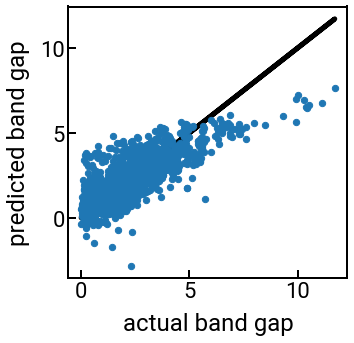

In [6]:
lr = LinearRegression()
kfold = KFold(n_splits=5, shuffle=False)
yhat = cross_val_predict(lr, X, y, cv=kfold)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y, yhat, s=40)
ax.plot(y, y, c='k', zorder=-5)
ax.set_xlabel('actual band gap')
ax.set_ylabel('predicted band gap')
# ax.set_aspect('equal')
plt.show()

<div class="alert alert-block alert-warning">
    <center><b>~ BREAK ~</b></center>
    At this point, we're going to give ourselves a short break before continuing further.
    Great work so far! 💪
</div>

## Model complexity

[Back to top](#Contents)

Wow, this featurization strategy is pretty cool, even if the new features can't perfectly predict experimental band gaps.
At least now we have an automated way to generate a bunch of physically-meaningful and interpretable features from the chemical formula, and it's conceivable that we can add _even more features_ from matminer or other packages/datasets, particularly if we account for the crystal structure.

But, if we continued in this way of blindly generating more and more features for ML, hoping to improve our model performance, then we'd actually fall for a trap! 🕳 
Note that each time we add a feature, at least for linear regression, we also add a parameter (another coefficient) to the linear regression model.
The addition of another parameter adds another degree of freedom that we must optimize for and increases the **model complexity**.

It is true that a more complex model should be able to learn more nuances _in the data that it was trained on_.
Hence, a more complex model will generally have lower **training error** than a simpler model (fewer parameters).
After all, physicist John von Neumann has [famously said](https://www.nature.com/articles/427297a), "With four parameters I can fit an elephant, and with five I can make him wiggle his trunk." 🐘

But what about _unseen data_, like the validation set in $k$-fold CV? 
If our model is a really complex polynomial and we have noisy or irregular data (always true in materials science), then it might not be a good approximation for new data, even when that data is an _interpolation_ rather than _extrapolation_ (where it would presumably do even worse).
Thus at some point, **the validation error will begin to increase** with model complexity, _even as the training error continues to decrease_.
At this point we say the model has started to **overfit** to the training data, and before this point, we might say the model is **underfitting**.
At the point where validation error bottoms out is the Goldilocks sweet spot. 🐻

The code below illustrates this point by performing linear regression with increasingly complex polynomial features and plotting (a) the model on the left, and (b) the training and validation errors on the right.
Note that we wrote several helper functions in a separate file to remove some of the clutter.
For example, `gen_data()` is not some "well-known" function available everywhere; it was hard-coded for this example.
Nonetheless, by revealing most of the important details, we hope to prove that we are not "gaming" anything.

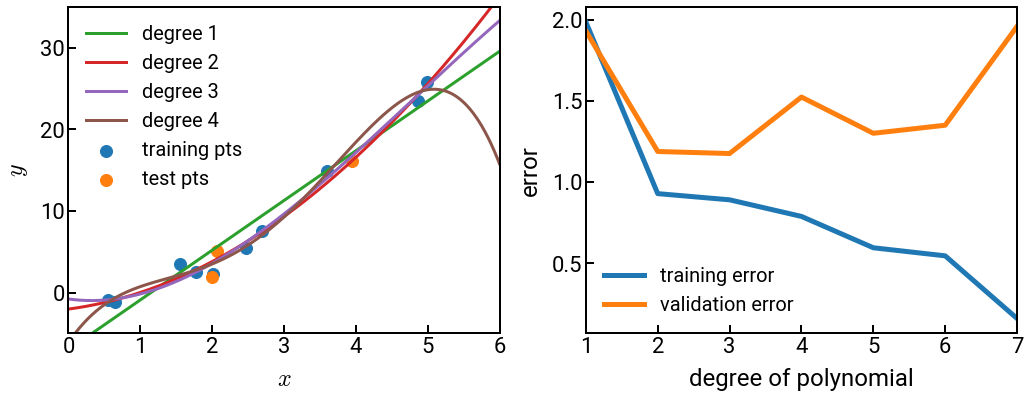

In [7]:
from helper_funcs_04 import *

# generate some data
dom = np.reshape(np.linspace(0, 6, 1000), (-1, 1))
X_train, y_train, X_test, y_test = gen_data(dom)

# create plot objects and initial points on left side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
ax[0].scatter(X_train, y_train, label='training pts')
ax[0].scatter(X_test, y_test, label='test pts')

# loop through increasingly complex models
train_errs, val_errs = [], []
degree = 8
for i in range(1, degree):

    # ML fitting helper function - return model and errors
    y_fit, train_err, val_err = ml_fitting(i, dom, X_train, y_train, X_test, y_test)
    train_errs.append(train_err)
    val_errs.append(val_err)
    
    # plot the low-degree polynomials for illustration on left side
    if i < 5:
        ax[0].plot(dom, y_fit, lw=3, label=f'degree {i}', c=f'C{i+1}')

# plots errors on the right and some nice styling
ax[1].plot(np.arange(1, degree), train_errs, label='training error')
ax[1].plot(np.arange(1 ,degree), val_errs, label='validation error')
plot_styling(ax, degree)
# fig.savefig('../../assets/fig/week_1/04/model_complexity.png')

## Feature selection

[Back to top](#Contents)

While the previous example used a non-materials example, we hope you'll believe us when we say that it happens with materials data too, more often than we would like. 😢
Therefore, we need a way to be able to perform **feature selection** after we have finished generating all of our features using matminer.

Once again, scikit-learn generously provides many built-in feature selection classes in the [`sklearn.feature_selection`](https://scikit-learn.org/stable/modules/feature_selection.html) module.
We're going to go ahead and use a rather simple [univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) tool called [`SelectKBest(score_func, k)`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) that has the following parameters:

- `score_func`: A scoring function callable that, for regression tasks, can either be [`f_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html) or [`mutual_info_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html).
These are functions imported from the `sklearn.feature_selection` module, and as callables we only need to write their name _without parentheses_ to the function arguments.
- `k`: An `int` for the number of top features to select.

**Pause and reflect**: How do we find the optimal value of `k`?

### Exercise: apply feature selection to the band gap prediction problem and identify the top 10 features.

**Challenge**: Can you then use only those 10 features to build a linear regression model?
Does the model perform better or worse?

In [9]:
bg_data = load_dataset('matbench_expt_gap')
bg_data = bg_data[bg_data['gap expt'] > 0].reset_index(drop=True)   # just look at positive band gaps, trims dataset
display(bg_data.head())    # only a composition and band gap!

,composition,gap expt
0,Ag0.5Ge1Pb1.75S4,1.83
1,Ag0.5Ge1Pb1.75Se4,1.51
2,Ag2GeS3,1.98
3,Ag2GeSe3,0.90
4,Ag2HgI4,2.47


## Conclusion

Congratulations on making it to the end! 🎉👏

There is a lot of information that we covered in this notebook, so it's totally reasonable if not everything clicked right away and you find yourself needing to revist these concepts.

Please don't hesitate to reach out on Slack if you have questions or concerns.